In [1]:
import scanpy as sc
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
#import doubletdetection
from scipy.stats import median_abs_deviation as mad
import numpy as np
import anndata as adt

In [2]:
import warnings 
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [4]:
path = '/home/ybeaumatin/Documents/Data processing pipeline/scP/Data/data.treatment_allconditions_pg_.xlsx'

# Dataset formating

In [4]:
sheets = pd.read_excel(path, sheet_name=None, header = None)

In [5]:
cles = list(sheets.keys())

In [6]:
cles

['Mock3dpi_pg',
 'GFP.NEG3dpi_pg',
 'GFP.POS3dpi_pg',
 'Mock6dpi_pg',
 'GFP.NEG6dpi_pg',
 'GFP.POS6dpi_pg']

In [7]:
adatas = []

for x in cles:
    sheet_part = sheets[x]
    var = sheet_part.iloc[1:, 0:5]  
    obs = pd.DataFrame(sheet_part.iloc[0, 5:])  
    data = sheet_part.iloc[1:, 5:].T

    adata = sc.AnnData(X=data, obs=obs, var=var) #create anndata
    
    #remodele the indexs
    #idx_var = pd.DataFrame(sheet_part.iloc[1:, 3]) 
    adata.obs.index = obs
    
    adata.obs.index = adata.obs.index.map(str)
    adata.obs.index = adata.obs.index.str.replace(r"[()']", "", regex=True)
    adata.obs.index = adata.obs.index.str.replace(";", "")
    adata.obs.index = adata.obs.index.str.replace(",", "")


    idx_var = pd.DataFrame(sheet_part.iloc[1:, 2])  # Index pour var (colonne cible)
    adata.var.index = [str(idx[0]) if isinstance(idx, tuple) else str(idx) for idx in idx_var.iloc[:, 0]]
    adata.var.index = [idx.replace("(", "").replace(")", "").replace("'", "").replace(";", "").replace(",", "") for idx in adata.var.index]
    
    adata.var.columns = sheet_part.iloc[0, 0:5]

    
    adata.obs = adata.obs.drop(columns=[0])
    
    adatas.append(adata)

In [8]:
adatas

[AnnData object with n_obs × n_vars = 145 × 5701
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 138 × 4142
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 133 × 2969
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 139 × 3223
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 108 × 3212
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 140 × 4385
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description']

In [9]:
def load_it(i, adata):
    adata.obs['Id'] = cles[i]
    return adata

In [10]:
adatas = [load_it(i, ad) for i, ad in enumerate(adatas)]

In [11]:
from scipy.sparse import csr_matrix
for ad in adatas: 
    
    if isinstance(ad.X, np.ndarray):
         ad.X = ad.X.astype(np.float32)

    if isinstance(ad.X, csr_matrix):
         ad.X = csr_matrix(ad.X, dtype=np.float32)
    # Convertir toutes les colonnes de obs et var en chaînes
    ad.obs = ad.obs.astype(str)
    ad.var = ad.var.astype(str)

    # Convertir les index d'obs et var en chaînes
    ad.obs.index = ad.obs.index.map(str)
    ad.var.index = ad.var.index.map(str)

In [12]:
for ad in adatas:
    unique_id = ad.obs['Id'][0]
    file_path = os.path.join('/home/ybeaumatin/Documents/Data processing pipeline/scP/Data/', f'adata_{unique_id}.h5ad')
    ad.write(file_path)
    print(f"Saved: {file_path}")

Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Data/adata_Mock3dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Data/adata_GFP.NEG3dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Data/adata_GFP.POS3dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Data/adata_Mock6dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Data/adata_GFP.NEG6dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Data/adata_GFP.POS6dpi_pg.h5ad


# Data exploration

In [5]:
adatas = []
data_dir = '/home/ybeaumatin/Documents/Data processing pipeline/scP/Data'

for filename in os.listdir(data_dir):
    if filename.endswith('.h5ad'):
            adata = sc.read_h5ad(os.path.join(data_dir, filename))
            adata.var_names_make_unique()
            adatas.append(adata)

print(f"Nombre de fichiers h5ad chargés avec succès : {len(adatas)}")


Nombre de fichiers h5ad chargés avec succès : 6


In [6]:
for ad in adatas:
    nbmiss = np.sum(np.isnan(ad.X))/ np.sum(np.size(ad.X)) *100# ad.X contient la matrice de données
    print(f"Pourcentage of NaN values: {nbmiss}%")

Pourcentage of NaN values: 15.965015451316821%
Pourcentage of NaN values: 36.266736224191334%
Pourcentage of NaN values: 34.17766997925349%
Pourcentage of NaN values: 28.933675895151083%
Pourcentage of NaN values: 26.015800618993325%
Pourcentage of NaN values: 14.870642901629822%


In [7]:
adatas

[AnnData object with n_obs × n_vars = 108 × 3212
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 133 × 2969
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 145 × 5701
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 139 × 3223
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 140 × 4385
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 138 × 4142
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description']

In [8]:
adatas[1].X

array([[    nan, 2108.71, 4227.87, ...,     nan,     nan, 1750.73],
       [    nan, 2618.78, 4938.56, ..., 4525.85,     nan,     nan],
       [    nan, 4620.57, 6304.49, ...,     nan,     nan,     nan],
       ...,
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan]],
      dtype=float32)

In [9]:
all_incorrect_indices = set()

for ad in adatas:
    print(ad.obs['Id'][0])
    ad.var['Genes'] = ad.var['Genes'].astype(str)
    if 'Genes' not in ad.var.columns:
        print("The column doesn't exist in adata.var")
    else:
        # Create a mask for the datas with date name
        date_mask = pd.to_datetime(ad.var['Genes'], format='%Y-%m-%d %H:%M:%S', errors='coerce').notna()
        other_date_mask = pd.to_datetime(ad.var['Genes'], format='%Y-%d-%m %H:%M:%S', errors='coerce').notna()

    # same for NaN
        nan_mask = ad.var['Genes'].astype(str).str.lower() == 'nan'

    # Combine
        incorrect_entries = date_mask | nan_mask | other_date_mask

        incorrect_genes = ad.var.loc[incorrect_entries, 'Genes']

        print("Incorrect name in column 'Genes' :")
        print(incorrect_genes)
        print(f"\nNombre total d'entrées incorrectes : {incorrect_entries.sum()}")
        print("\nIncorrect distribution :")
        print(incorrect_genes.value_counts())

   
        print("\nIncorrect Index :")
        print(incorrect_genes.index.tolist())
        all_incorrect_indices.update(incorrect_genes.index)


print("\nTous les indices incorrects uniques :")
print(sorted(list(all_incorrect_indices)))
print(f"\nNombre total d'indices incorrects uniques : {len(all_incorrect_indices)}")

GFP.NEG6dpi_pg
Incorrect name in column 'Genes' :
SYMC_HUMAN    2001-03-01 00:00:00
Name: Genes, dtype: object

Nombre total d'entrées incorrectes : 1

Incorrect distribution :
Genes
2001-03-01 00:00:00    1
Name: count, dtype: int64

Incorrect Index :
['SYMC_HUMAN']
GFP.POS3dpi_pg
Incorrect name in column 'Genes' :
SEPT2_HUMAN    2002-09-01 00:00:00
SEPT7_HUMAN    2007-09-01 00:00:00
YI025_HUMAN                    nan
SEPT8_HUMAN    2008-09-01 00:00:00
SEP11_HUMAN    2011-09-01 00:00:00
SEP10_HUMAN    2010-09-01 00:00:00
SEPT9_HUMAN    2009-09-01 00:00:00
Name: Genes, dtype: object

Nombre total d'entrées incorrectes : 7

Incorrect distribution :
Genes
2002-09-01 00:00:00    1
2007-09-01 00:00:00    1
nan                    1
2008-09-01 00:00:00    1
2011-09-01 00:00:00    1
2010-09-01 00:00:00    1
2009-09-01 00:00:00    1
Name: count, dtype: int64

Incorrect Index :
['SEPT2_HUMAN', 'SEPT7_HUMAN', 'YI025_HUMAN', 'SEPT8_HUMAN', 'SEP11_HUMAN', 'SEP10_HUMAN', 'SEPT9_HUMAN']
Mock3dpi_pg


In [10]:
wrong_gene_name = {
"IGA2_HUMAN":"IGA2",
"IGL1_HUMAN":"IGL1",
"SEP10_HUMAN":"SEPTIN10",
"SEP11_HUMAN":"SEPTIN11",
"SEPT2_HUMAN":"SEPTIN2",
"SEPT5_HUMAN":"SEPTIN5",
"SEPT6_HUMAN":"SEPTIN6",
"SEPT7_HUMAN":"SEPTIN7",
"SEPT8_HUMAN":"SEPTIN8",
"SEPT9_HUMAN":"SEPTIN9",
"SYMC_HUMAN":"MARS1",
"SYMM_HUMAN":"MARS2",
"YI025_HUMAN":"YI025",
"YJ005_HUMAN":"YJ005"
}

In [11]:
def corriger_noms_genes(adatas, corrections):
    for ad in adatas:

        ad.var['Genes'] = ad.var['Genes'].astype(str)
        

        ad.var['Genes'] = ad.var['Genes'].replace(corrections)
        
        date_mask = pd.to_datetime(ad.var['Genes'], format='%Y-%m-%d %H:%M:%S', errors='coerce').notna()
        
        mask_a_corriger = date_mask | (ad.var['Genes'].str.lower() == 'nan')
        ad.var.loc[mask_a_corriger, 'Genes'] = ad.var.index[mask_a_corriger].str.split('_').str[0]


corriger_noms_genes(adatas, wrong_gene_name)

In [12]:
all_incorrect_indices = set()

for ad in adatas:
    print(ad.obs['Id'][0])
    ad.var['Genes'] = ad.var['Genes'].astype(str)
    if 'Genes' not in ad.var.columns:
        print("The column doesn't exist in adata.var")
    else:
        # Create a mask for the datas with date name
        date_mask = pd.to_datetime(ad.var['Genes'], format='%Y-%m-%d %H:%M:%S', errors='coerce').notna()
        other_date_mask = pd.to_datetime(ad.var['Genes'], format='%Y-%d-%m %H:%M:%S', errors='coerce').notna()

    # same for NaN
        nan_mask = ad.var['Genes'].astype(str).str.lower() == 'nan'

    # Combine
        incorrect_entries = date_mask | nan_mask | other_date_mask

        incorrect_genes = ad.var.loc[incorrect_entries, 'Genes']

        print("Incorrect name in column 'Genes' :")
        print(incorrect_genes)
        print(f"\nNombre total d'entrées incorrectes : {incorrect_entries.sum()}")
        print("\nIncorrect distribution :")
        print(incorrect_genes.value_counts())

   
        print("\nIncorrect Index :")
        print(incorrect_genes.index.tolist())
        all_incorrect_indices.update(incorrect_genes.index)


print("\nTous les indices incorrects uniques :")
print(sorted(list(all_incorrect_indices)))
print(f"\nNombre total d'indices incorrects uniques : {len(all_incorrect_indices)}")

GFP.NEG6dpi_pg
Incorrect name in column 'Genes' :
Series([], Name: Genes, dtype: object)

Nombre total d'entrées incorrectes : 0

Incorrect distribution :
Series([], Name: count, dtype: int64)

Incorrect Index :
[]
GFP.POS3dpi_pg
Incorrect name in column 'Genes' :
Series([], Name: Genes, dtype: object)

Nombre total d'entrées incorrectes : 0

Incorrect distribution :
Series([], Name: count, dtype: int64)

Incorrect Index :
[]
Mock3dpi_pg
Incorrect name in column 'Genes' :
Series([], Name: Genes, dtype: object)

Nombre total d'entrées incorrectes : 0

Incorrect distribution :
Series([], Name: count, dtype: int64)

Incorrect Index :
[]
Mock6dpi_pg
Incorrect name in column 'Genes' :
Series([], Name: Genes, dtype: object)

Nombre total d'entrées incorrectes : 0

Incorrect distribution :
Series([], Name: count, dtype: int64)

Incorrect Index :
[]
GFP.POS6dpi_pg
Incorrect name in column 'Genes' :
Series([], Name: Genes, dtype: object)

Nombre total d'entrées incorrectes : 0

Incorrect distri

### Differences between datasets

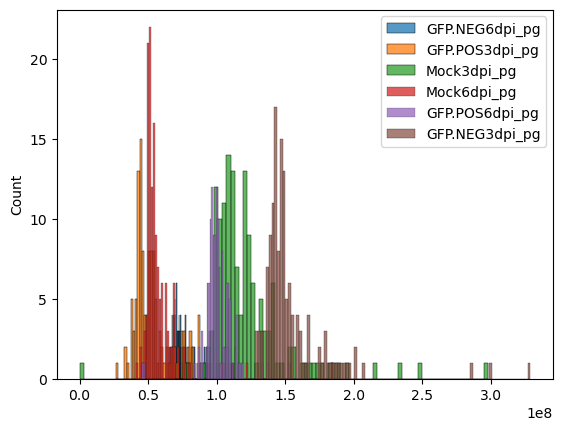

In [13]:
for ad in adatas:
    ax = sns.histplot(np.nan_to_num(ad.X, nan=0.0).sum(1), bins=100, kde=False, label = ad.obs['Id'][0])
    ax.legend()
#sum of cells for each 

In [14]:
adatas[1].X

array([[    nan, 2108.71, 4227.87, ...,     nan,     nan, 1750.73],
       [    nan, 2618.78, 4938.56, ..., 4525.85,     nan,     nan],
       [    nan, 4620.57, 6304.49, ...,     nan,     nan,     nan],
       ...,
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan]],
      dtype=float32)

In [15]:
adata_raw = adt.concat(adatas, join="outer", index_unique="-", merge="unique")

In [16]:
adata_raw.X = np.nan_to_num(adata_raw.X, nan=0.0)

In [17]:
sc.pp.highly_variable_genes(adata_raw, n_top_genes=2000, flavor="cell_ranger", batch_key='Id')

Text(0.5, 1.0, 'Distribution des gènes hautement variables à travers les lots')

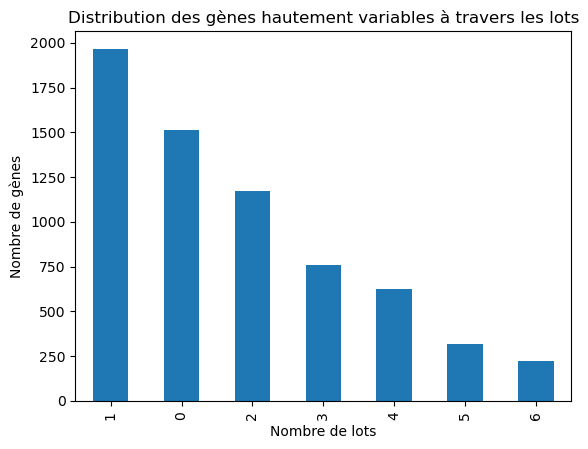

In [18]:
n_batches = adata_raw.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches
ax.set_xlabel("Nombre de lots")
ax.set_ylabel("Nombre de gènes")
ax.set_title("Distribution des gènes hautement variables à travers les lots")

In [19]:
adatas[0].var

,Protein.Group,Protein.Ids,Protein.Names,Genes,First.Protein.Description
NUD4B_HUMANNUDT4_HUMAN,A0A024RBG1;Q9NZJ9,A0A024RBG1;Q9NZJ9,NUD4B_HUMAN;NUDT4_HUMAN,NUDT4;NUDT4B,Diphosphoinositol polyphosphate phosphohydrola...
GAL3A_HUMANGAL3B_HUMAN,A0A0B4J2D5;P0DPI2,A0A0B4J2D5;P0DPI2,GAL3A_HUMAN;GAL3B_HUMAN,GATD3;GATD3B,Putative glutamine amidotransferase-like class...
A0A7S6HGT3_CVH22,A0A7S6HGT3,A0A7S6HGT3,A0A7S6HGT3_CVH22,N,Nucleoprotein
RBM47_HUMAN,A0AV96,A0AV96,RBM47_HUMAN,RBM47,RNA-binding protein 47
IFT56_HUMAN,A0AVF1,A0AVF1,IFT56_HUMAN,TTC26,Intraflagellar transport protein 56
...,...,...,...,...,...
M3K4_HUMAN,Q9Y6R4,Q9Y6R4,M3K4_HUMAN,MAP3K4,Mitogen-activated protein kinase kinase kinase 4
SCIN_HUMAN,Q9Y6U3,Q9Y6U3,SCIN_HUMAN,SCIN,Scinderin
CAN7_HUMAN,Q9Y6W3,Q9Y6W3,CAN7_HUMAN,CAPN7,Calpain-7
WASF2_HUMAN,Q9Y6W5,Q9Y6W5,WASF2_HUMAN,WASF2,Wiskott-Aldrich syndrome protein family member 2


6570


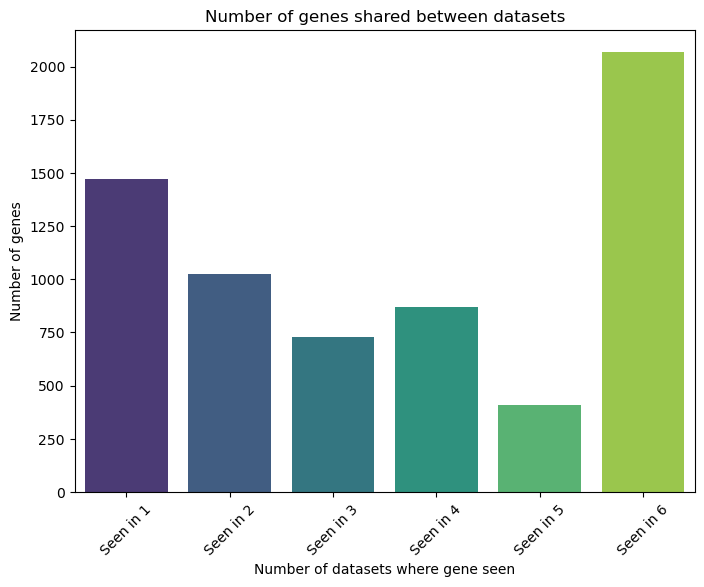

In [20]:
all_genes = list(set().union(*[set(adata.var_names) for adata in adatas]))
print(len(all_genes))

presence_matrix = pd.DataFrame(0, index=all_genes, columns=[f"Dataset {ad.obs['Id'][0]}" for ad in adatas])

for adata in adatas:
    presence_matrix.loc[adata.var_names, f"Dataset {adata.obs['Id'][0]}"] = 1  

compte = pd.DataFrame(0, index=all_genes, columns=[f"Seen in {i+1}" for i in range(len(adatas))])
sum_presencematrix = presence_matrix.sum(1)

for gene in all_genes:
    presence_count = sum_presencematrix[gene] 
    compte.loc[gene, f"Seen in {presence_count}"] = 1  


column_sums = compte.sum(axis=0)


plt.figure(figsize=(8, 6))
sns.barplot(x=column_sums.index, y=column_sums.values, palette="viridis")

plt.xlabel("Number of datasets where gene seen")
plt.ylabel("Number of genes")
plt.title("Number of genes shared between datasets")


plt.xticks(rotation=45)

plt.show()

In [21]:
adatas[1].X

array([[    nan, 2108.71, 4227.87, ...,     nan,     nan, 1750.73],
       [    nan, 2618.78, 4938.56, ..., 4525.85,     nan,     nan],
       [    nan, 4620.57, 6304.49, ...,     nan,     nan,     nan],
       ...,
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan]],
      dtype=float32)

## Erase non detected genes in batch

In [22]:
protein_diff = set(adatas[2].var_names)
protein_diff2 = set(adatas[3].var_names)
all_protein_diff = (protein_diff-protein_diff2)  ^(protein_diff2-protein_diff)

In [23]:
adatas_red = [adata.copy() for adata in adatas]
for i,ad in enumerate(adatas_red): 
    adatas_red[i] = ad[:, ~ad.var_names.isin(all_protein_diff)]
adatas_red

[View of AnnData object with n_obs × n_vars = 108 × 2837
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 View of AnnData object with n_obs × n_vars = 133 × 2402
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 View of AnnData object with n_obs × n_vars = 145 × 3065
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 View of AnnData object with n_obs × n_vars = 139 × 3065
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 View of AnnData object with n_obs × n_vars = 140 × 3113
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 View of AnnData object with n_obs × n_vars = 138 × 2926
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.

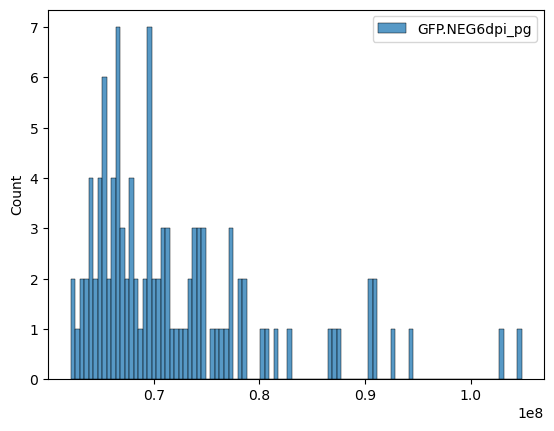

In [24]:
ax = sns.histplot(np.nan_to_num(adatas_red[0].X, nan=0.0).sum(1), bins=100, kde=False, label = adatas_red[0].obs['Id'][0])
ax.legend()

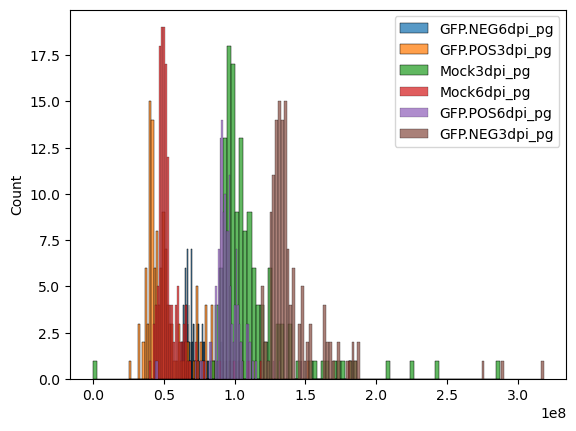

In [25]:
for ad in adatas_red:
    ax = sns.histplot(np.nan_to_num(ad.X, nan=0.0).sum(1), bins=100, kde=False, label = ad.obs['Id'][0])
    ax.legend()
#sum of cells for each

In [26]:
adatas_red[1].X

ArrayView([[    nan, 2108.71, 4227.87, ...,     nan,     nan, 1750.73],
           [    nan, 2618.78, 4938.56, ..., 4525.85,     nan,     nan],
           [    nan, 4620.57, 6304.49, ...,     nan,     nan,     nan],
           ...,
           [    nan,     nan,     nan, ...,     nan,     nan,     nan],
           [    nan,     nan,     nan, ...,     nan,     nan,     nan],
           [    nan,     nan,     nan, ...,     nan,     nan,     nan]],
          dtype=float32)

### Normalization tests

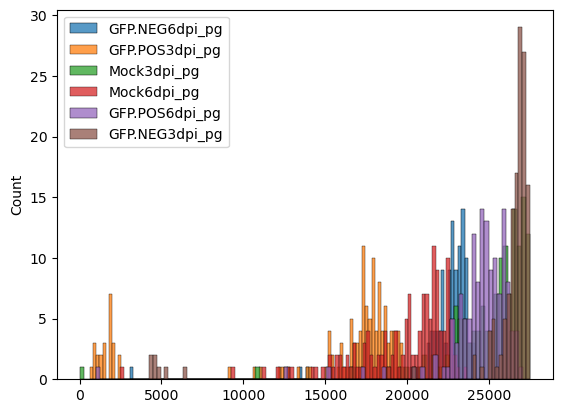

In [27]:
for adata in adatas_red:
    ad = adata.copy()
    ad.X = np.nan_to_num(ad.X, nan=0.0)
    scales_counts = sc.pp.normalize_total(ad, target_sum=None, inplace=False)
    ax = sns.histplot(sc.pp.log1p(scales_counts["X"], copy=True).sum(1), bins=100, kde=False, label = ad.obs['Id'][0])
    ax.legend()

In [28]:
adatas_red[1].X

ArrayView([[    nan, 2108.71, 4227.87, ...,     nan,     nan, 1750.73],
           [    nan, 2618.78, 4938.56, ..., 4525.85,     nan,     nan],
           [    nan, 4620.57, 6304.49, ...,     nan,     nan,     nan],
           ...,
           [    nan,     nan,     nan, ...,     nan,     nan,     nan],
           [    nan,     nan,     nan, ...,     nan,     nan,     nan],
           [    nan,     nan,     nan, ...,     nan,     nan,     nan]],
          dtype=float32)

In [29]:
from scipy.sparse import csr_matrix

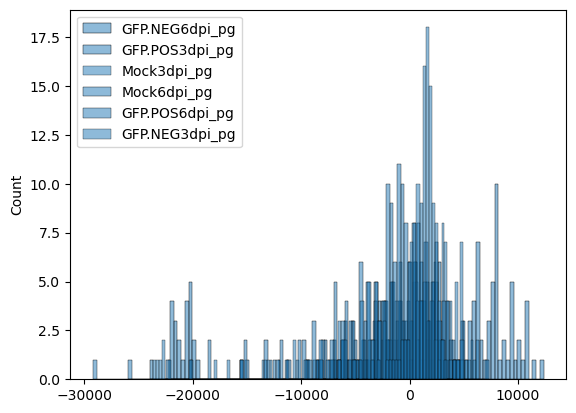

In [30]:
for adata in adatas_red:
    ad = adata.copy()
    ad.X = np.nan_to_num(ad.X, nan=0.0)
    analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(ad, inplace=False)
    X_fixed = analytic_pearson["X"]
    X_fixed[np.isnan(X_fixed)] = 0 
    ax = sns.histplot(csr_matrix(X_fixed).sum(1), bins=100, kde=False, label = ad.obs['Id'][0])
    ax.legend()

In [31]:
adatas_red[1].X

ArrayView([[    nan, 2108.71, 4227.87, ...,     nan,     nan, 1750.73],
           [    nan, 2618.78, 4938.56, ..., 4525.85,     nan,     nan],
           [    nan, 4620.57, 6304.49, ...,     nan,     nan,     nan],
           ...,
           [    nan,     nan,     nan, ...,     nan,     nan,     nan],
           [    nan,     nan,     nan, ...,     nan,     nan,     nan],
           [    nan,     nan,     nan, ...,     nan,     nan,     nan]],
          dtype=float32)

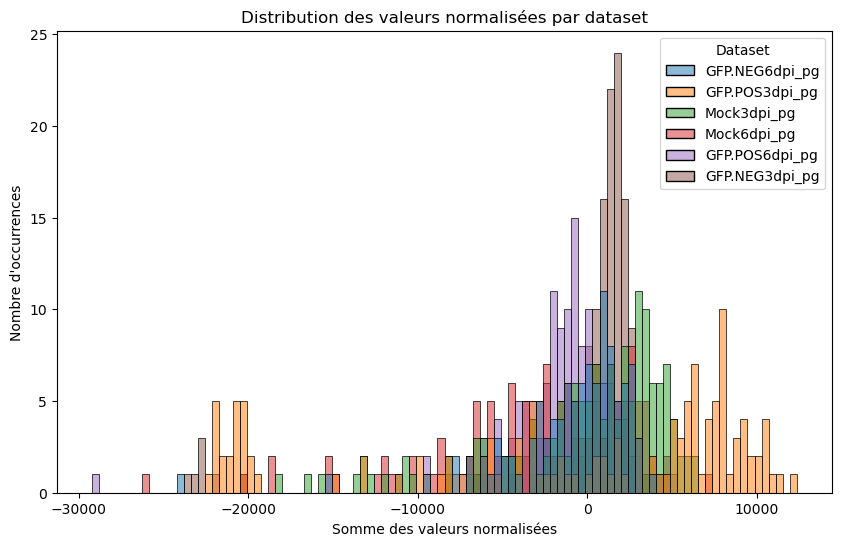

In [32]:
plot_data = []

for adata in adatas_red:
    ad = adata.copy()
    ad.X = np.nan_to_num(ad.X, nan=0.0)  
    analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(ad, inplace=False)
    
    X_fixed = analytic_pearson["X"]
    X_fixed[np.isnan(X_fixed)] = 0  

    plot_data.extend([(x, ad.obs['Id'][0]) for x in csr_matrix(X_fixed).sum(1).A1])

df_plot = pd.DataFrame(plot_data, columns=["Somme Normalisée", "Dataset"])

plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df_plot, x="Somme Normalisée", hue="Dataset", bins=100, kde=False, palette="tab10")

plt.xlabel("Somme des valeurs normalisées")
plt.ylabel("Nombre d'occurrences")
plt.title("Distribution des valeurs normalisées par dataset")

# Afficher le plot
plt.show()


In [33]:
adatas_red[1].X

ArrayView([[    nan, 2108.71, 4227.87, ...,     nan,     nan, 1750.73],
           [    nan, 2618.78, 4938.56, ..., 4525.85,     nan,     nan],
           [    nan, 4620.57, 6304.49, ...,     nan,     nan,     nan],
           ...,
           [    nan,     nan,     nan, ...,     nan,     nan,     nan],
           [    nan,     nan,     nan, ...,     nan,     nan,     nan],
           [    nan,     nan,     nan, ...,     nan,     nan,     nan]],
          dtype=float32)

### QC metrics

In [34]:
adatas_red_snan = [adata.copy() for adata in adatas]

In [35]:
for ad in adatas_red_snan:
    ad.X = np.nan_to_num(ad.X, nan=0.0) 
    

In [36]:
def qc(adata):
    sc.pp.calculate_qc_metrics(adata, inplace = True, percent_top = [20], log1p=True)
    return adata

In [37]:
adatas_red_snan = [qc(ad) for ad in adatas_red_snan]

In [38]:
adatas_red_snan[0].obs

,Id,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes
GFP_neg_6dpi/TU017444PAP_Slot1-06_1_5848.d,GFP.NEG6dpi_pg,2623,7.872455,81561328.0,18.216866,37.252361
GFP_neg_6dpi/TU017445PAP_Slot1-07_1_5849.d,GFP.NEG6dpi_pg,2588,7.859027,76149296.0,18.148207,38.597347
GFP_neg_6dpi/TU017446PAP_Slot1-08_1_5850.d,GFP.NEG6dpi_pg,2666,7.888710,82286816.0,18.225721,38.940031
GFP_neg_6dpi/TU017481PAP_Slot1-18_1_5885.d,GFP.NEG6dpi_pg,2443,7.801391,94369072.0,18.362724,50.758749
GFP_neg_6dpi/TU017482PAP_Slot1-19_1_5886.d,GFP.NEG6dpi_pg,2791,7.934513,76694224.0,18.155336,38.086211
...,...,...,...,...,...,...
GFP_neg_6dpi/TU017666PAP_Slot1-80_1_6060.d,GFP.NEG6dpi_pg,2977,7.999007,70791848.0,18.075254,32.171278
GFP_neg_6dpi/TU017667PAP_Slot1-81_1_6061.d,GFP.NEG6dpi_pg,2848,7.954723,73236280.0,18.109201,38.902020
GFP_neg_6dpi/TU017670PAP_Slot1-88_1_6064.d,GFP.NEG6dpi_pg,2815,7.943073,72736544.0,18.102354,37.440140
GFP_neg_6dpi/TU017671PAP_Slot1-89_1_6065.d,GFP.NEG6dpi_pg,2845,7.953670,68100832.0,18.036501,33.586806


In [39]:
df = pd.concat([x.obs for x in adatas_red_snan])

In [40]:
df = df.sort_values('Id')

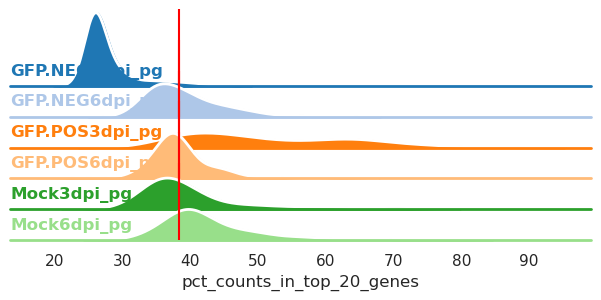

In [41]:
value = "pct_counts_in_top_20_genes"

with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}), sns.plotting_context("notebook"):
    g = sns.FacetGrid(df, row="Id", hue="Id", aspect=15, height=0.5, palette="tab20")

    g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, value)

    g.figure.subplots_adjust(hspace=-.6)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    for ax in g.axes.flat:
        ax.axvline(x=df[value].median(), color='r', linestyle='-')

    plt.show()

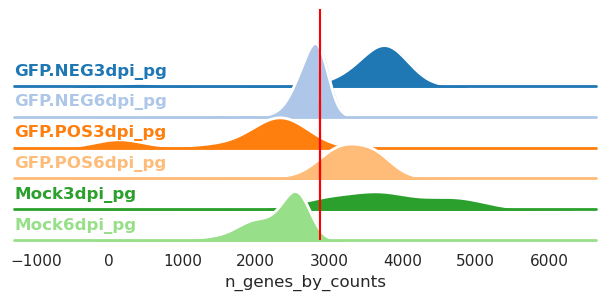

In [42]:
value = "n_genes_by_counts"

with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}), sns.plotting_context("notebook"):
    g = sns.FacetGrid(df, row="Id", hue="Id", aspect=15, height=0.5, palette="tab20")

    g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, value)

    g.figure.subplots_adjust(hspace=-.6)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    for ax in g.axes.flat:
        ax.axvline(x=df[value].median(), color='r', linestyle='-')

    plt.show()

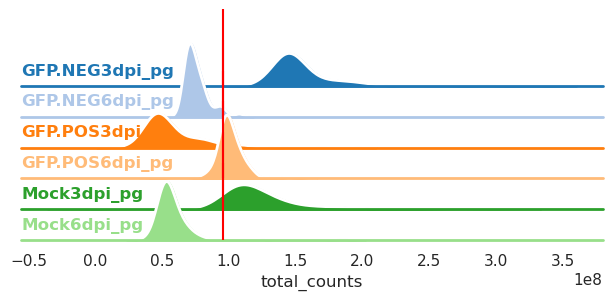

In [43]:
value = "total_counts"

with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}), sns.plotting_context("notebook"):
    g = sns.FacetGrid(df, row="Id", hue="Id", aspect=15, height=0.5, palette="tab20")

    g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, value)

    g.figure.subplots_adjust(hspace=-.6)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    for ax in g.axes.flat:
        ax.axvline(x=df[value].median(), color='r', linestyle='-')

    plt.show()

In [44]:
adatas_red[1].X

ArrayView([[    nan, 2108.71, 4227.87, ...,     nan,     nan, 1750.73],
           [    nan, 2618.78, 4938.56, ..., 4525.85,     nan,     nan],
           [    nan, 4620.57, 6304.49, ...,     nan,     nan,     nan],
           ...,
           [    nan,     nan,     nan, ...,     nan,     nan,     nan],
           [    nan,     nan,     nan, ...,     nan,     nan,     nan],
           [    nan,     nan,     nan, ...,     nan,     nan,     nan]],
          dtype=float32)

### Highly var proteins btw batches

In [46]:
adata_red = adt.concat(adatas_red, join="outer", index_unique="-", merge="unique")

In [47]:
adata_red.X = np.nan_to_num(adata_red.X, nan=0.0)

In [48]:
adatas_red[1].X

ArrayView([[    nan, 2108.71, 4227.87, ...,     nan,     nan, 1750.73],
           [    nan, 2618.78, 4938.56, ..., 4525.85,     nan,     nan],
           [    nan, 4620.57, 6304.49, ...,     nan,     nan,     nan],
           ...,
           [    nan,     nan,     nan, ...,     nan,     nan,     nan],
           [    nan,     nan,     nan, ...,     nan,     nan,     nan],
           [    nan,     nan,     nan, ...,     nan,     nan,     nan]],
          dtype=float32)

In [49]:
sc.pp.highly_variable_genes(adata_red, n_top_genes=2000, flavor="cell_ranger", batch_key='Id')

Text(0.5, 1.0, 'Distribution des gènes hautement variables à travers les lots')

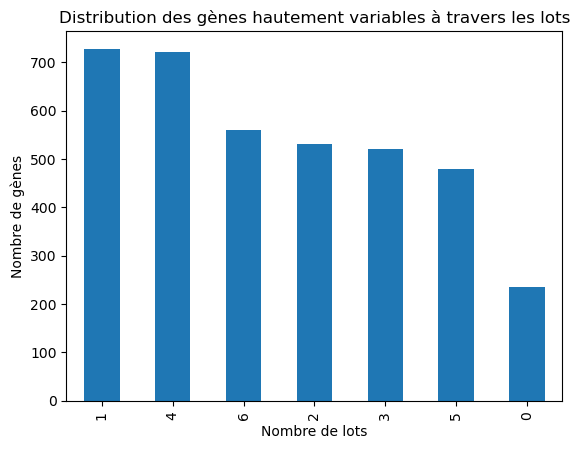

In [50]:
n_batches = adata_red.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches
ax.set_xlabel("Nombre de lots")
ax.set_ylabel("Nombre de gènes")
ax.set_title("Distribution des gènes hautement variables à travers les lots")

### Shared proteins btw batches

3776


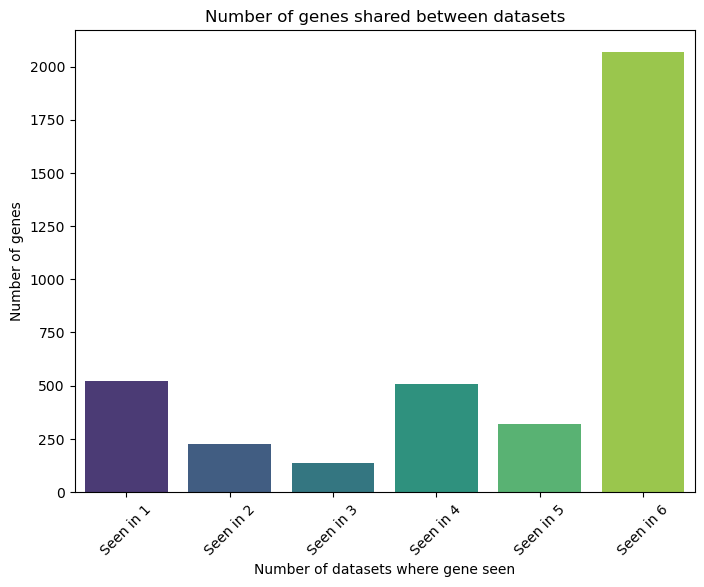

In [51]:
all_genes = list(set().union(*[set(adata.var_names) for adata in adatas_red]))
print(len(all_genes))

presence_matrix = pd.DataFrame(0, index=all_genes, columns=[f"Dataset {ad.obs['Id'][0]}" for ad in adatas_red])

for adata in adatas_red:
    presence_matrix.loc[adata.var_names, f"Dataset {adata.obs['Id'][0]}"] = 1  

compte = pd.DataFrame(0, index=all_genes, columns=[f"Seen in {i+1}" for i in range(len(adatas_red))])
sum_presencematrix = presence_matrix.sum(1)

for gene in all_genes:
    presence_count = sum_presencematrix[gene] 
    compte.loc[gene, f"Seen in {presence_count}"] = 1  


column_sums = compte.sum(axis=0)


plt.figure(figsize=(8, 6))
sns.barplot(x=column_sums.index, y=column_sums.values, palette="viridis")

plt.xlabel("Number of datasets where gene seen")
plt.ylabel("Number of genes")
plt.title("Number of genes shared between datasets")


plt.xticks(rotation=45)

plt.show()

#### Test pp QC (not interesting)

In [53]:
def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]
    
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    
    return (M > np.median(M) + nmads * mad(M))


In [54]:
def pp(adata):

    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 5)
           
    adata = adata[~bool_vector]
    adata.uns['cells_removed'] = sum(bool_vector)
    return adata


In [56]:
adatas_red_pp = [pp(ad.copy()) for ad in adatas_red_snan]

In [57]:
adatas_red_pp

[AnnData object with n_obs × n_vars = 99 × 3212
     obs: 'Id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'cells_removed',
 AnnData object with n_obs × n_vars = 104 × 2969
     obs: 'Id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'cells_removed',
 AnnData object with n_obs × n_vars = 136 × 5701
     obs: 'Id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct

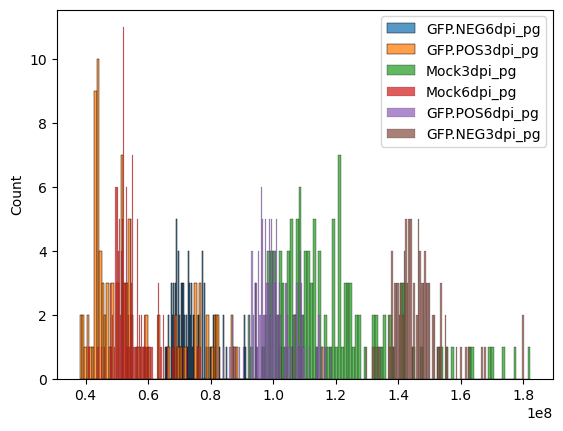

In [58]:
for ad in adatas_red_pp:
    ax = sns.histplot(np.nan_to_num(ad.X, nan=0.0).sum(1), bins=100, kde=False, label = ad.obs['Id'][0])
    ax.legend()

In [60]:
os.makedirs('/home/ybeaumatin/Documents/Data processing pipeline/scP/Output/Formated_data',exist_ok = True)

In [61]:
for ad in adatas_red:
    unique_id = ad.obs['Id'][0]
    file_path = os.path.join('/home/ybeaumatin/Documents/Data processing pipeline/scP/Output/Formated_data', f'adata_{unique_id}.h5ad')
    ad.write(file_path)
    print(f"Saved: {file_path}")

Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Output/Formated_data/adata_GFP.NEG6dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Output/Formated_data/adata_GFP.POS3dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Output/Formated_data/adata_Mock3dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Output/Formated_data/adata_Mock6dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Output/Formated_data/adata_GFP.POS6dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Output/Formated_data/adata_GFP.NEG3dpi_pg.h5ad


In [43]:
adatas_red[1].X

array([[ 5544.32,  7190.33, 10628.2 , ...,  3585.08,  5518.76,  7944.28],
       [ 4120.03,  5809.38, 12093.3 , ...,  2425.32,  6372.72,  8097.24],
       [ 5531.19, 11922.  ,  9237.77, ...,  4091.65,  5796.29,  7071.44],
       ...,
       [ 3669.94,  6447.75,  8868.58, ...,  3251.86,  4072.56,  8222.58],
       [ 3975.58,  4283.43,  9022.19, ...,  3668.98,  4208.38,  8004.19],
       [ 2984.47,  3099.07,  8867.48, ...,  2828.09,  4721.6 ,  7507.2 ]],
      dtype=float32)

In [3]:
adatas_red = []
data_dir = 'G:/Data processing pipeline 0.1 Yohan/scP/Output/Formated_data'

for filename in os.listdir(data_dir):
    if filename.endswith('.h5ad'):
            adata = sc.read_h5ad(os.path.join(data_dir, filename))
            adata.var_names_make_unique()
            adatas_red.append(adata)

print(f"Nombre de fichiers h5ad chargés avec succès : {len(adatas_red)}")

Nombre de fichiers h5ad chargés avec succès : 6


In [4]:
adatas_red

[AnnData object with n_obs × n_vars = 138 × 2926
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 108 × 2837
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 133 × 2402
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 140 × 3113
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 145 × 3065
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 139 × 3065
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description']

In [5]:
adatas_red[1].X

array([[ 5544.32,  7190.33, 10628.2 , ...,  3585.08,  5518.76,  7944.28],
       [ 4120.03,  5809.38, 12093.3 , ...,  2425.32,  6372.72,  8097.24],
       [ 5531.19, 11922.  ,  9237.77, ...,  4091.65,  5796.29,  7071.44],
       ...,
       [ 3669.94,  6447.75,  8868.58, ...,  3251.86,  4072.56,  8222.58],
       [ 3975.58,  4283.43,  9022.19, ...,  3668.98,  4208.38,  8004.19],
       [ 2984.47,  3099.07,  8867.48, ...,  2828.09,  4721.6 ,  7507.2 ]],
      dtype=float32)

In [6]:
print(type(adatas_red[0].X))

<class 'numpy.ndarray'>


In [7]:
np.isnan(adatas_red[1].X).any()

True

In [8]:
pip install MissForest

In [10]:
pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 15.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install --upgrade joblib

Note: you may need to restart the kernel to use updated packages.


In [11]:
from missforest import MissForest

In [8]:
nan_percentage = np.isnan(adatas_red[0].X).mean()
print(f"Proportion de NaN dans X : {nan_percentage:.2%}")

Proportion de NaN dans X : 9.95%


In [53]:
#miss_forest = MissForest()
#X = adatas_red[1].X.copy()
#X = X.astype(np.float64)
# Impute away
#X_imputed = miss_forest.fit_transform(X)

In [ ]:
X_imputed

In [19]:
df = adatas_red[1].to_df()

In [20]:
df

,NUD4B_HUMANNUDT4_HUMAN,GAL3A_HUMANGAL3B_HUMAN,RBM47_HUMAN,IFT56_HUMAN,UBA6_HUMAN,ESYT2_HUMAN,SHOT1_HUMAN,ARH37_HUMAN,SPD2B_HUMAN,DCD2B_HUMAN,...,DC1L1_HUMAN,OAS3_HUMAN,NEMO_HUMAN,IF2B2_HUMAN,SQOR_HUMAN,AP1M2_HUMAN,SCIN_HUMAN,CAN7_HUMAN,WASF2_HUMAN,S23IP_HUMAN
GFP_neg_6dpi/TU017444PAP_Slot1-06_1_5848.d,5544.319824,7190.330078,10628.200195,8177.069824,7789.330078,3961.179932,1475.040039,NaN,5580.620117,5271.279785,...,6874.870117,6402.839844,NaN,6189.899902,10673.200195,16079.700195,5024.819824,3585.080078,5518.759766,7944.279785
GFP_neg_6dpi/TU017445PAP_Slot1-07_1_5849.d,4120.029785,5809.379883,12093.299805,7686.870117,9992.629883,5632.649902,2039.119995,1564.219971,6048.750000,NaN,...,5182.580078,5987.819824,2411.169922,5107.189941,13627.400391,18186.099609,3842.020020,2425.320068,6372.720215,8097.240234
GFP_neg_6dpi/TU017446PAP_Slot1-08_1_5850.d,5531.189941,11922.000000,9237.769531,5372.549805,9355.629883,3833.600098,1198.880005,1159.510010,8719.780273,2213.090088,...,3992.600098,8136.399902,NaN,4024.449951,27889.900391,18617.599609,6413.250000,4091.649902,5796.290039,7071.439941
GFP_neg_6dpi/TU017481PAP_Slot1-18_1_5885.d,3538.610107,4117.390137,11211.299805,6511.060059,9290.389648,6372.120117,2129.600098,1470.349976,5594.189941,1130.030029,...,7247.430176,9667.559570,1784.819946,3959.459961,14346.700195,16424.699219,5458.490234,4127.660156,7450.600098,7689.709961
GFP_neg_6dpi/TU017482PAP_Slot1-19_1_5886.d,3947.270020,4609.279785,9855.700195,3729.000000,8664.080078,5318.250000,1927.599976,1381.020020,6649.089844,2616.280029,...,6398.950195,6531.589844,3014.449951,3085.330078,9252.530273,15430.099609,4633.049805,3542.750000,5723.770020,7147.060059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GFP_neg_6dpi/TU017666PAP_Slot1-80_1_6060.d,3435.610107,7031.229980,8337.830078,4649.819824,8561.000000,4275.089844,883.783020,878.869995,5415.910156,1891.140015,...,4932.629883,6656.939941,2109.280029,3254.199951,15783.200195,20787.599609,5435.629883,2317.370117,4287.729980,7590.379883
GFP_neg_6dpi/TU017667PAP_Slot1-81_1_6061.d,4150.890137,4533.629883,8880.929688,6285.930176,9341.320312,4227.770020,1705.930054,1013.489990,5642.899902,2708.229980,...,5300.439941,8613.250000,NaN,2383.169922,11830.299805,22021.500000,5558.740234,4594.759766,5059.979980,7253.779785
GFP_neg_6dpi/TU017670PAP_Slot1-88_1_6064.d,3669.939941,6447.750000,8868.580078,6193.600098,9415.959961,4753.040039,1265.550049,NaN,6205.109863,3001.979980,...,5199.520020,8333.209961,2303.500000,2978.860107,12911.799805,20902.400391,5792.609863,3251.860107,4072.560059,8222.580078
GFP_neg_6dpi/TU017671PAP_Slot1-89_1_6065.d,3975.580078,4283.430176,9022.190430,5971.810059,8408.629883,3305.949951,1079.209961,601.354980,5957.490234,1913.750000,...,5476.319824,6447.560059,NaN,3456.790039,12528.299805,21360.300781,4297.620117,3668.979980,4208.379883,8004.189941


In [54]:
#miss_forest = MissForest()
# Impute away
#X_imputed = miss_forest.fit_transform(df)

In [9]:
os.makedirs( 'G:/Data processing pipeline 0.1 Yohan/scP/Output/missforest_completed',exist_ok = True)

In [ ]:
for ad in adatas_red:
    
    miss_forest = MissForest()
    X = ad.X.copy()
    X = X.astype(np.float64)
    # Impute away
    X_imputed = miss_forest.fit_transform(X)
    ad.X = X_imputed
    print(ad)
    unique_id = ad.obs['Id'][0]
    file_path = os.path.join('G:/Data processing pipeline 0.1 Yohan/scP/Output/missforest_completed', f'adata_{unique_id}.h5ad')
    ad.write(file_path)
    print(f"Saved: {file_path}")


In [10]:
for ad in adatas_red:
    nan_percentage = np.isnan(ad.X).mean()
    print(f"Proportion de NaN dans X : {nan_percentage:.2%}")

Proportion de NaN dans X : 9.95%
Proportion de NaN dans X : 12.67%
Proportion de NaN dans X : 31.40%
Proportion de NaN dans X : 16.42%
Proportion de NaN dans X : 12.67%
Proportion de NaN dans X : 27.06%


In [11]:
import time

In [12]:
os.makedirs( 'G:/Data processing pipeline 0.1 Yohan/scP/Output/missforest_completed',exist_ok = True)

In [ ]:
from missforest import MissForest


for ad in adatas_red:
    mf = MissForest()
    X = ad.X.copy()
    X = X.astype(np.float64)

    X_df = pd.DataFrame(X)
    X_imputed = mf.fit_transform(X_df)
    X_imputed = X_imputed.to_numpy()
    try:
       print("Erreur OOB :", mf.oob_imputation_error_) 
    except:
        print('Error OOB not found')

    ad.X = X_imputed.astype(np.float32)

    print(ad)
    unique_id = ad.obs['Id'][0]
    time.sleep(1)

    file_path = os.path.join('G:/Data processing pipeline 0.1 Yohan/scP/Output/missforest_completed', f'adata_{unique_id}.h5ad')
    
    try:
        ad.write(file_path)
        print(f"Saved: {file_path}")
        
    except Exception as e:
        print(f"Erreur lors de la sauvegarde de {file_path} : {e}")
        

  File "C:\Users\test\anaconda3\envs\annot\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\test\anaconda3\envs\annot\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\test\anaconda3\envs\annot\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\test\anaconda3\envs\annot\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [23]:
from joblib.externals.loky.backend.context import cpu_count
print(cpu_count(only_physical_cores=True))

16


In [39]:
X_imputed

array([[1.00778000e+05, 1.86113000e+06, 8.90818984e+04, ...,
        1.66608356e+04, 1.99545082e+03, 1.77994995e+03],
       [1.18313000e+05, 1.70619000e+06, 8.19176016e+04, ...,
        1.66460132e+04, 1.98100182e+03, 1.73226751e+03],
       [8.71135000e+04, 1.87065000e+06, 8.83887031e+04, ...,
        1.66630523e+04, 1.97112210e+03, 1.98883997e+03],
       ...,
       [2.15830000e+05, 2.49033000e+06, 1.08526000e+05, ...,
        1.66711738e+04, 1.99039852e+03, 1.73503250e+03],
       [5.54737000e+05, 1.87110000e+06, 5.88664000e+05, ...,
        1.66856949e+04, 1.98082172e+03, 1.73698868e+03],
       [4.21168000e+05, 2.52772000e+06, 7.96528984e+04, ...,
        1.66889446e+04, 1.98603849e+03, 1.73453689e+03]])

In [1]:
pip install ehrapy

  Using cached ehrapy-0.12.0-py3-none-any.whl.metadata (18 kB)
  Using cached dowhy-0.12-py3-none-any.whl.metadata (18 kB)
  Using cached fhiry-4.0.0-py2.py3-none-any.whl.metadata (6.4 kB)
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached fknni-1.2.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached lamin_utils-0.13.11-py2.py3-none-any.whl.metadata (940 bytes)
  Using cached lifelines-0.30.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached miceforest-6.0.3-py3-none-any.whl.metadata (35 kB)
  Using cached missingno-0.5.2-py3-none-any.whl.metadata (639 bytes)
  Using cached pyampute-0.0.3-py3-none-any.whl.metadata (1.3 kB)
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached scikit_misc-0.5.1-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
  Using cached session_info2-0.1.2-py3-none-any.whl.metadata (2.5 kB)
  Using cached tableone-0.9.1-py3-none-any.whl.metadata (

In [9]:
import ehrapy as ep
from sklearn.impute import KNNImputer

In [12]:
#imputation using KNN
imputer = KNNImputer(n_neighbors=2)
X = imputer.fit_transform(adatas_red[0].X)
print(X)

[[  8564.74    19492.7    160103.     ...  38799.4      1263.54
   15399.4   ]
 [  8564.74    21016.      76261.7    ...  39394.9      1198.02
   14672.9   ]
 [  4725.915   20000.1    169301.     ...  38115.8      1473.9
   14499.3   ]
 ...
 [ 10039.3     22417.1    124142.     ...  51473.7      2307.
   14743.2   ]
 [  7904.9746 119562.5    123474.95   ...  45482.9      1699.925
   16548.55  ]
 [ 13106.25    21872.2    155874.     ...  52962.5      1010.91
   16261.9   ]]


In [14]:
pip install missingpy

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install sklearn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates from a subpr

In [19]:
from missingpy import MissForest

imputer = MissForest(n_estimators=100, max_iter=10, random_state=42)
adatas_red[0].X = imputer.fit_transform(adatas_red[0].X)

ModuleNotFoundError: No module named 'sklearn.neighbors.base'